In [0]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd

%pylab inline




  Created wheel for ruptures: filename=ruptures-1.0.3-cp36-none-any.whl size=55251 sha256=bafe18e5647bdd8ddf43b7a3075ff5a2340d800bba838320e2fcabd861aaa3de
  Stored in directory: /root/.cache/pip/wheels/8b/a2/15/6e7b600d1415d6d3e746e3004dc23eef3bf7778d35e6afebac
Successfully built ruptures
Populating the interactive namespace from numpy and matplotlib


# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

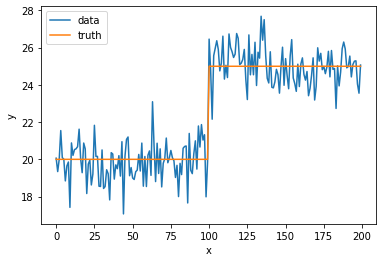

In [0]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data") 
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

**Figure 1.** A synthetic dataset with 200 points generated by a Gaussian stationary process.



# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [0]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables
    
    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(ym[i:]) -  f(ym[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
    return(poc, before, after)  

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 19.86, mean after: 25.04


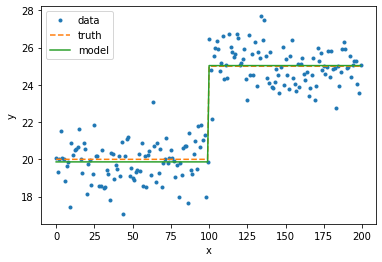

In [0]:
poc, before, after = maxdiff(ym)   
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Figure 2.** A synthetic dataset with 200 points generated by a Gaussian stationary process. Lines fitting the modeled POC and true POC are represented. 

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa4#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

In [0]:
def poc_mse(y):

    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    error = np.nansum(np.sqrt((y[:] - f(ym[:] ))**2))
    for i in range(1, N):
        #print(poc, before, after, error)
        #print(i)
        error_here1 = np.nansum(np.sqrt((y[:i] - f(ym[:i] ))**2))
        error_here2 = np.nansum(np.sqrt((y[i:] - f(ym[i:] ))**2 ))
        error_here = np.nansum( [error_here1, error_here2] )

        diff_here = np.abs(f(ym[i:]) -  f(ym[:i]))

        if( (error_here < error) and ( diff_here > diff )):

            error = error_here
            diff = diff_here

            #if (diff > diff_here ):
            #    diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
        else :
            continue
    return poc, before, after, error

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}, error is: {:.2f}".format(*poc_mse(ym)))

poc: 100.00, mean before: 19.86, mean after: 25.04, error is: 164.18


In [0]:
len(ym)

200

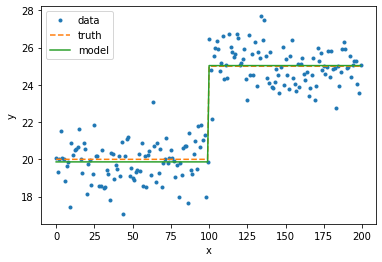

In [0]:
poc, before, after, error = poc_mse(ym)   
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Figure 3.** A synthetic dataset with 200 points generated by a Gaussian stationary process. Lines fitting the modeled POC and true POC using the mean square error are represented. 

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [0]:
mu1, mu2 = 20, 25
s1, s2 = 1, 4
ys1 = mu1 + np.random.randn(100)*s1
ys2 = mu1 + np.random.randn(100)*s2
ys = np.concatenate((ys1, ys2))
#ys = np.concatenate([np.random.randn(100)  + mu1 , np.random.randn(100) * s2 + mu1])

In [0]:
def maxval(y, sigma=True):
    """calculates the POC as the points that maximized the difference between 
                the mean or variance before and the mean after the POC
    y: vector of endogenouos variables 
    sigma: finds the POC that maximizes the difference between before/after POC variance 
                (optional, default is before/after mean)"""
    
    N= len(y)
    if sigma == False:
      f = np.nanmean
    else:
        f = np.nanstd
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff_here > diff:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)  

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxval(ys, sigma = True)))

 

#print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))
   

#print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ys, sigma=True)))


poc: 100.00, mean before: 0.96, mean after: 3.92


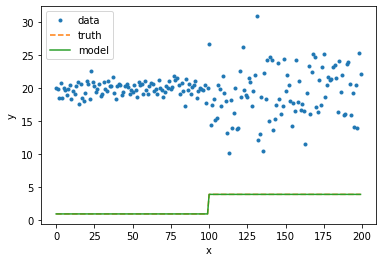

In [0]:
poc, before, after = maxval(ys)   
pl.plot(x, ys, '.', label="data")
pl.plot(range(200), [np.std(ys1)] * 100 + [np.std(ys2)] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ys) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Figure 4.** A synthetic dataset with 200 points generated by a Gaussian stationary process. Lines fitting the modeled POC and true POC using the differece of variance are represented. 

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

In [0]:
import ruptures as rpt

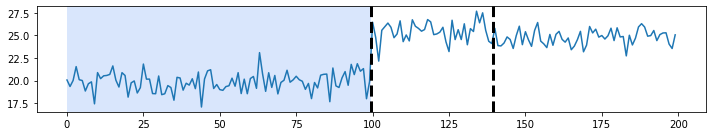

In [0]:

# detection
algo = rpt.Pelt(model='l1').fit(ym)
result = algo.predict(pen=5)

# display
rpt.display(ym, [100], result)
pl.show()

**Figure 5.** A synthetic dataset with 200 points. Lines indicating the POC using the Pelt (model L1) method are represented. 

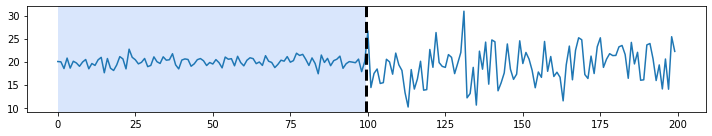

In [0]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=5)

# display
rpt.display(ys, [100], result)
pl.show()

**Figure 6.** A synthetic dataset with 200 points. Lines indicating the POC using the Pelt (model rbf) method are represented. 

# read in the data from LANL earthquake prediction 
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [0]:
eq1 = pd.read_csv('http://fbb.space/mltsa/LALNeq.csv')
eq1.describe()

,Unnamed: 0,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06,4.500000e+06
mean,2.250000e+06,4.616407e+00,8.852012e-01
std,1.299038e+06,2.614006e+01,3.374432e-01
min,0.000000e+00,-4.621000e+03,3.008971e-01
25%,1.125000e+06,2.000000e+00,5.934956e-01
50%,2.250000e+06,5.000000e+00,8.849986e-01
75%,3.374999e+06,7.000000e+00,1.177597e+00
max,4.499999e+06,3.252000e+03,1.469100e+00


In [0]:
eq1.head()

,Unnamed: 0,acoustic_data,time_to_failure
0,0,12,1.4691
1,1,6,1.4691
2,2,8,1.4691
3,3,5,1.4691
4,4,8,1.4691


# using rupture

Go through the documentation of rupture. 

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)




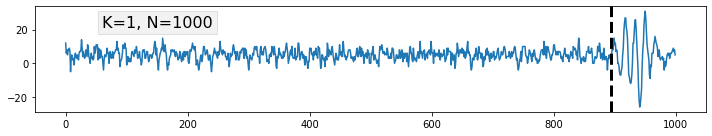

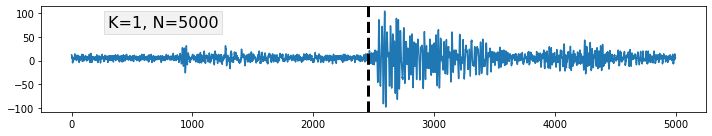

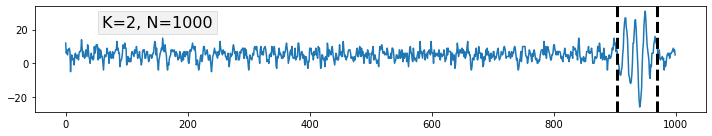

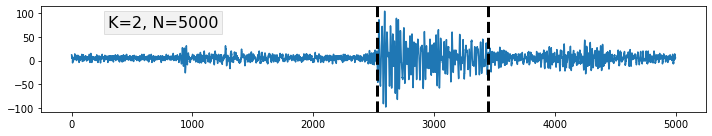

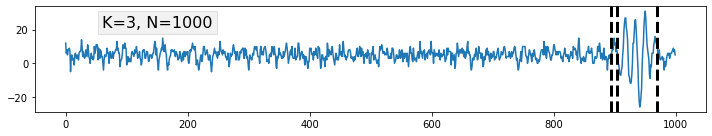

KeyboardInterrupt: ignored

In [0]:
ind = [1000, 5000, 10000]
k = [1, 2, 3]
for kk in k :

    for xx in ind :

        ac_dat = array(eq1.acoustic_data[:xx])
        algo1 = rpt.Dynp(model="rbf").fit(ac_dat)
        result = algo1.predict(n_bkps=kk)

        # display
        fig, axs = rpt.display(eq1.acoustic_data.values[:xx], [], result);
        axs[0].text(0.1, 0.8, 'K=%s, N=%s' %(kk, xx), transform=axs[0].transAxes, 
                    fontsize=16, bbox=dict(facecolor='gray', alpha=0.1))
        plt.show()

#algo1 = rpt.show.(eq1, 1)
#result = algo1.predict(n_bkps=1)

# display
#rpt.display(eq1.acoustic_data.values[:10000], [], result)
#plt.show()


**Figure 7.** A series of synthetic time series with 1,000, 5,000, and 10,000 points. Lines indicating the POC using various break points (k) are represented using the 'rbf' model and O(kN^2).

Find a method that has computational complexity O(Nlog(N))

Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

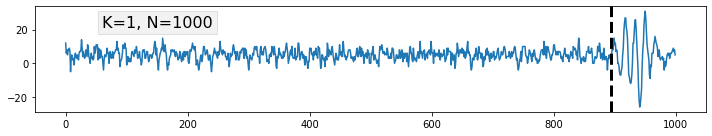

KeyboardInterrupt: ignored

In [0]:
ind = [1000, 5000, 10000]
k = [1, 2, 3]
for kk in k :

    for xx in ind :

        ac_dat = array(eq1.acoustic_data[:xx])
        algo1 = rpt.Binseg(model="rbf").fit(ac_dat)
        result = algo1.predict(n_bkps=kk)

        # display
        fig, axs = rpt.display(eq1.acoustic_data.values[:xx],[] , result);
        axs[0].text(0.1, 0.8, 'K=%s, N=%s' %(kk, xx), transform=axs[0].transAxes, 
                    fontsize=16, bbox=dict(facecolor='gray', alpha=0.1))
        plt.show( )

**Figure 8.** A series of synthetic time series with 1,000, 5,000, and 10,000 points. Lines indicating the POC using various break points (k) are represented using the 'rbf' model and O(Nlog(N).

In [0]:
ind = [10000]
k = [6]
for kk in k :

    for xx in ind :

        ac_dat = array(eq1.acoustic_data[:xx])
        algo1 = rpt.Binseg(model="rbf", jump = 5).fit(ac_dat)
        result1 = algo1.predict(n_bkps=kk)

#for kk in k :
        #ac_dat = array(eq1.acoustic_data[:xx])
       # algo2 = rpt.Dynp(model="rbf", jump = 5).fit(ac_dat)
        #result2 = algo2.predict(n_bkps=kk)
#print(result1, result2)
        # display
       # fig, axs = rpt.display(eq1.acoustic_data.values[:xx],[] , result);
        #axs[0].text(0.1, 0.8, 'K=%s, N=%s' %(kk, xx), transform=axs[0].transAxes, 
                  #  fontsize=16, bbox=dict(facecolor='gray', alpha=0.1))
      #  plt.show( )

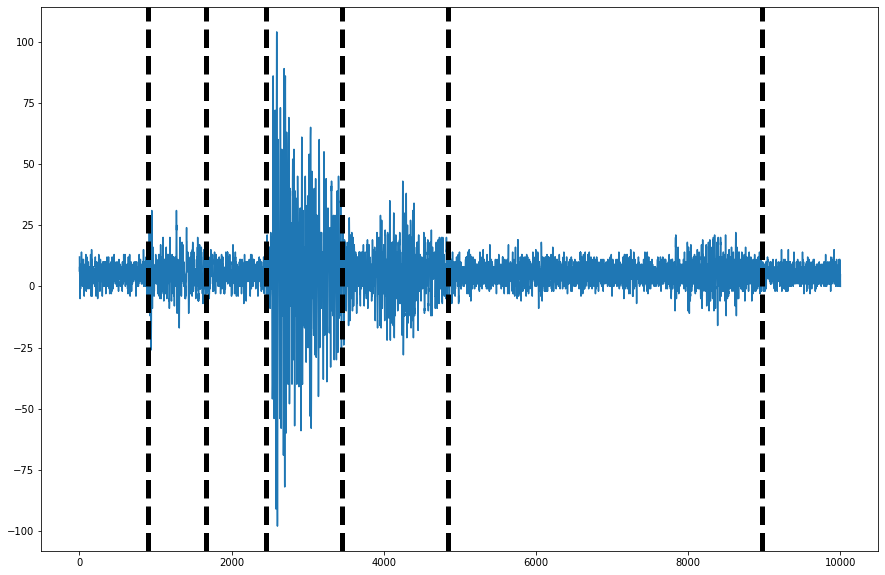

In [0]:
pl.figure(figsize = (15,10))
pl.plot (ac_dat)
for xx in result1[:-1] :
  pl.axvline(xx,color = 'k', ls='--',lw = 5)

#for xx in result2[:-1] :
 # pl.axvline(xx,color = 'r', ls='--',lw = 5)


**Figure 9.** A 10,000 point time series segmented into three sections. Lines indicating the POC using various break points (k) are represented using the 'rbf' model and O(Nlog(N)). Six segments were used to ensure three segments were easily able to be extracted. Data were analyzed in the model in steps of five time points to ensure a sensitive measure. Three segments were successfully segregated isolating various parts of the synthetic earthquake data. 
